# Continual Learning for Sentence Representations Using Conceptors

## Some prepartion

###  load packages



In [0]:
# using colab usage
  
!pip install -q gdown
!pip install -q gensim
!pip install -q pandas scipy seaborn


resourceFile = '/content/'


import gensim
import pandas as pd
import numpy as np
import scipy
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

from gensim.models.keyedvectors import KeyedVectors

import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
from sklearn.decomposition import TruncatedSVD, randomized_svd
from sklearn.metrics.pairwise import cosine_similarity



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### load word vectors



In [0]:


# load glove word vector
!gdown https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2
  
glove = KeyedVectors.load_word2vec_format(resourceFile + 'gensim_glove.840B.300d.txt.bin', binary=True)
print('The glove embedding has been loaded!')





Downloading...
From: https://drive.google.com/uc?id=1Ty2exMyi-XOufY-v81RJfiPvnintHuy2
To: /content/gensim_glove.840B.300d.txt.bin
2.65GB [00:58, 45.2MB/s]
The glove embedding has been loaded!


### load STS Benchmark

The STS Benchmark brings together the English data from the SemEval sentence similarity taskshttp://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark and 
 http://ixa2.si.ehu.es/stswiki/images/e/ee/Stscompanion.tar.gz


In [0]:
!wget http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz # STS
!tar xvzf Stsbenchmark.tar.gz

!wget http://ixa2.si.ehu.es/stswiki/images/e/ee/Stscompanion.tar.gz # STS companian
!tar xvzf Stscompanion.tar.gz
  
  

def load_sts_dataset(filename):
    # For a STS dataset, loads the relevant information: the sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            #sent_pairs.append((ts[5], ts[6], float(ts[4])))
            if len(ts) == 7 or len(ts) == 9:
                sent_pairs.append((re.sub("[^0-9]", "", ts[2]) + '-' + ts[1] , ts[5], ts[6], float(ts[4])))
            elif len(ts) == 6 or len(ts) == 8:
                sent_pairs.append((re.sub("[^0-9]", "", ts[1]) + '-' + ts[0] , ts[4], ts[5], float(ts[3])))
            else:
                print('data format is wrong!!!')
    return pd.DataFrame(sent_pairs, columns=["year-task", "sent_1", "sent_2", "sim"])


def load_all_sts_dataset():
    # Loads all of the STS datasets 
    stsbenchmarkDir = resourceFile + 'stsbenchmark/'
    stscompanionDir = resourceFile + 'stscompanion/'
    sts_train = load_sts_dataset(os.path.join(stsbenchmarkDir, "sts-train.csv"))    
    sts_dev = load_sts_dataset(os.path.join(stsbenchmarkDir, "sts-dev.csv"))
    sts_test = load_sts_dataset(os.path.join(stsbenchmarkDir, "sts-test.csv"))
    sts_other = load_sts_dataset(os.path.join(stscompanionDir, "sts-other.csv"))
    sts_mt = load_sts_dataset(os.path.join(stscompanionDir, "sts-mt.csv"))
    
    sts_all = pd.concat([sts_train, sts_dev, sts_test, sts_other, sts_mt ])
    
    return sts_all

sts_all = load_all_sts_dataset()




# show some sample sts data    
sts_all[:5] 


--2018-12-09 14:58:29--  http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.es (ixa2.si.ehu.es)... 158.227.106.100
Connecting to ixa2.si.ehu.es (ixa2.si.ehu.es)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409630 (400K) [application/x-gzip]
Saving to: ‘Stsbenchmark.tar.gz’

Stsbenchmark.tar.gz 100%[===================>] 400.03K   425KB/s    in 0.9s    

2018-12-09 14:58:31 (425 KB/s) - ‘Stsbenchmark.tar.gz’ saved [409630/409630]

stsbenchmark/
stsbenchmark/readme.txt
stsbenchmark/sts-test.csv
stsbenchmark/correlation.pl
stsbenchmark/LICENSE.txt
stsbenchmark/sts-dev.csv
stsbenchmark/sts-train.csv
--2018-12-09 14:58:33--  http://ixa2.si.ehu.es/stswiki/images/e/ee/Stscompanion.tar.gz
Resolving ixa2.si.ehu.es (ixa2.si.ehu.es)... 158.227.106.100
Connecting to ixa2.si.ehu.es (ixa2.si.ehu.es)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267977 (262K) [application/x-gzip]
Sa

,year-task,sent_1,sent_2,sim
0,2012-MSRvid,A plane is taking off.,An air plane is taking off.,5.00
1,2012-MSRvid,A man is playing a large flute.,A man is playing a flute.,3.80
2,2012-MSRvid,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,2012-MSRvid,Three men are playing chess.,Two men are playing chess.,2.60
4,2012-MSRvid,A man is playing the cello.,A man seated is playing the cello.,4.25


### load SIF repository

In [0]:
!git clone https://github.com/PrincetonML/SIF # SIF repository


wikiWordsPath = resourceFile + '/SIF/auxiliary_data/enwiki_vocab_min200.txt' # https://github.com/PrincetonML/SIF/blob/master/auxiliary_data/enwiki_vocab_min200.txt

frequencies = {}
with open(wikiWordsPath, "r+") as f_in:
    for line in f_in:
        frequencies[line.split(' ')[0]] = float(line.split(' ')[1])
        
        


Cloning into 'SIF'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 2.80 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (55/55), done.


### define a class for sentences

In [0]:
class Sentence:
  def __init__(self, sentence):
    self.raw = sentence
    normalized_sentence = sentence.replace("‘", "'").replace("’", "'")
    self.tokens = [t.lower() for t in nltk.word_tokenize(normalized_sentence)]
        
   

### define a class for sentences
Divide STS dataset into different domains: 'twitter', 'forums', 'OnWN', 'captions', 'news'

In [0]:
stsbenchmarkDir = resourceFile + 'stsbenchmark/'
stscompanionDir = resourceFile + 'stscompanion/'

sent_pairs = []


for sts_string in ['sts-train.csv', 'sts-test.csv', 'sts-dev.csv']:
    filename = os.path.join(stsbenchmarkDir, sts_string)
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            domain = ts[0].split('-')[1]
            
            if domain == 'forum':
               domain = 'forums'
            
            sent_pairs.append((domain , ts[5], ts[6], float(ts[4])))
            
            
with tf.gfile.GFile(os.path.join(stscompanionDir, 'sts-other.csv'), "r") as f:
    for line in f:
        ts = line.strip().split("\t")
        domain = ts[0].split('.')[-1]

        if domain == 'OnWN':
            domain = 'WordNet' 
            sent_pairs.append((domain , ts[4], ts[5], float(ts[3])))

        if domain == 'tweet-news':
            domain = 'tweets' 
            sent_pairs.append((domain , ts[4], ts[5], float(ts[3])))    

            
df_all_domains = pd.DataFrame(sent_pairs, columns=["domain", "sent_1", "sent_2", "sim"])

In [0]:
def load_sts_by_domain():
    # Divide STS datasets based on their year and tasks
    sts_by_domain = {}
    
    for domain in df_all_domains['domain'].unique():
        print(domain)
        indices = [i for i, x in enumerate(list(df_all_domains['domain'])) if x == domain]
        
        pairs = df_all_domains.iloc[indices]
        
#         sts_by_domain[domain] = pairs[:maxNr]
        sts_by_domain[domain] = pairs
        
    return sts_by_domain
  
sts_by_domain = load_sts_by_domain()


captions
forums
news
WordNet
tweets


In [0]:
domains = sts_by_domain.keys()

for domain in domains:
    print('size of the dataset', domain, ':', len(sts_by_domain[domain]))
# len(sts_by_domain['forums']) 

size of the dataset captions : 3250
size of the dataset forums : 1079
size of the dataset news : 4299
size of the dataset WordNet : 2061
size of the dataset tweets : 750


In [0]:

df_list = ['tweets', 'forums', 'WordNet', 'captions', 'news']

freqs=frequencies
a =0.001
total_freq = sum(freqs.values())

model = eval('glove')
pre_embedding_dict = {}

tokenVecs_dict = {}

  
for df_string in df_list:
    print(df_string)
    
    df = sts_by_domain[df_string]
    sentences1 = [Sentence(s) for s in df['sent_1']]
    sentences2 = [Sentence(s) for s in df['sent_2']]

    # SIF requires us to first collect all sentence embeddings and then perform 
    # common component analysis.
    embeddings = []
    allTokens = []
    for (sent1, sent2) in zip(sentences1, sentences2): 

        tokens1 =  sent1.tokens
        tokens2 =  sent2.tokens

        tokens1 = [token for token in tokens1 if token in model and token.islower()]
        tokens2 = [token for token in tokens2 if token in model and token.islower()]

        weights1 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens1]
        weights2 = [a/(a+freqs.get(token,0)/total_freq) for token in tokens2]

        embedding1 = np.average([model[token] for token in tokens1], axis=0, weights=weights1)
        embedding2 = np.average([model[token] for token in tokens2], axis=0, weights=weights2)

        embeddings.append(embedding1)
        embeddings.append(embedding2)

        allTokens.extend(tokens1)
        allTokens.extend(tokens2)
        
    pre_embedding_dict[df_string] = embeddings

    
    allTokens = list(set(allTokens).intersection(model.vocab))

    tokenVecs = [model[token] for token in allTokens ]
    tokenVecs_dict[df_string] = tokenVecs
    
   
    
    

def test_extra_data_sif(model_str, test_df_string, train_df_string_list):
    model = eval(model_str)
    df = sts_by_domain[test_df_string]
    
    
    target_embedding = np.array(pre_embedding_dict[test_df_string])

    extra_embeddings = []
    
    for i in np.arange(len(train_df_string_list)):
        extra_embeddings = extra_embeddings + pre_embedding_dict[train_df_string_list[i]]


    X =  np.array(extra_embeddings)
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc =  svd.components_
    embeddings_proj = target_embedding - target_embedding.dot(pc.transpose()) * pc


    sims = [cosine_similarity(embeddings_proj[idx*2].reshape(1, -1), 
                              embeddings_proj[idx*2+1].reshape(1, -1))[0][0] 
            for idx in range(int(len(embeddings_proj)/2))]


    pearson_correlation = round(scipy.stats.pearsonr(sims, df['sim'])[0] * 100,1)

    return pearson_correlation

tweets
forums
WordNet
captions
news


In [0]:

df_list = ['news', 'captions', 'WordNet', 'forums', 'tweets']
print('training corpus presented: large cardinality -> small cardinality')

training corpus presented: large cardinality -> small cardinality


## Conduct baseline algorithms and CA

### (1) corpus-specialized SIF

In [0]:
SIF_specialize_result = []
for item in df_list:
    temp = test_extra_data_sif('glove', item, [item])
    SIF_specialize_result.append(temp)
    print(item, temp)

news 67.5
captions 81.2
WordNet 82.7
forums 60.1
tweets 73.9


### (2) train-from-scratch SIF

In [0]:
print(df_list)

myList = []

sif_all_train_result = []

countTask = 1
for item in df_list:
  sif_this_train_result = []

  print('======')
  myList.append(item)
  
  print('training SIF on corpus', myList)
  print('---')
  
  for j in np.arange(len(df_list)):
#       pearson_correlation = test_extra_data_sif('glove', df_list[j], [item])
      pearson_correlation = test_extra_data_sif('glove', df_list[j], myList)

      print('testing result of SIF on', df_list[j], ':', pearson_correlation)
      sif_this_train_result.append(pearson_correlation)
  countTask += 1
  
  sif_all_train_result.append(sif_this_train_result)
print('======')


['news', 'captions', 'WordNet', 'forums', 'tweets']
training SIF on corpus ['news']
---
testing result of SIF on news : 67.5
testing result of SIF on captions : 77.8
testing result of SIF on WordNet : 78.0
testing result of SIF on forums : 53.8
testing result of SIF on tweets : 72.9
training SIF on corpus ['news', 'captions']
---
testing result of SIF on news : 66.7
testing result of SIF on captions : 80.5
testing result of SIF on WordNet : 79.5
testing result of SIF on forums : 54.6
testing result of SIF on tweets : 73.8
training SIF on corpus ['news', 'captions', 'WordNet']
---
testing result of SIF on news : 66.2
testing result of SIF on captions : 80.1
testing result of SIF on WordNet : 81.0
testing result of SIF on forums : 55.8
testing result of SIF on tweets : 74.7
training SIF on corpus ['news', 'captions', 'WordNet', 'forums']
---
testing result of SIF on news : 66.0
testing result of SIF on captions : 80.0
testing result of SIF on WordNet : 81.4
testing result of SIF on forum

### (3) Conceptor-aided (CA)

In [0]:
def NOT(C, out_mode = "simple"):
  """
  Compute NOT operation of conceptor.
  
  @param R: conceptor matrix
  @param out_mode: output mode ("simple"/"complete")
  
  @return not_C: NOT C
  @return U: eigen vectors of not_C
  @return S: eigen values of not_C
  """
  
  dim = C.shape[0]
  
  not_C = np.eye(dim) - C
  

  if out_mode == "complete":
    U, S, _ = np.linalg.svd(not_C)
    return not_C, U, S
  else:
    return not_C
  
def AND(C, B, out_mode = "simple", tol = 1e-14):
  """
  Compute AND Operation of two conceptor matrices
  
  @param C: a conceptor matrix
  @param B: another conceptor matrix
  @param out_mode: output mode ("simple"/"complete")
  @param tol: adjust parameter for almost zero
  
  @return C_and_B: C AND B
  @return U: eigen vectors of C_and_B
  @return S: eigen values of C_and_B
  """
  
  dim = C.shape[0]
  
  UC, SC, _ = np.linalg.svd(C)
  UB, SB, _ = np.linalg.svd(B)
  
  num_rank_C = np.sum((SC > tol).astype(float))
  num_rank_B = np.sum((SB > tol).astype(float))
  
  UC0 = UC[:, int(num_rank_C):]
  UB0 = UB[:, int(num_rank_B):]
  
  W, sigma, _ = np.linalg.svd(UC0.dot(UC0.T) + UB0.dot(UB0.T))
  num_rank_sigma = np.sum((sigma > tol).astype(float))
  Wgk = W[:, int(num_rank_sigma):]
  
  C_and_B = Wgk.dot(np.linalg.inv(Wgk.T.dot(np.linalg.pinv(C, tol) + np.linalg.pinv(B, tol) - np.eye(dim)).dot(Wgk))).dot(Wgk.T)
  

  if out_mode =="complete":
    U, S, _ = np.linalg.svd(C_and_B)
    return C_and_B, U, S
  else:
    return C_and_B
  
def OR(R, Q, out_mode = "simple"):
  """
  Compute OR operation of two conceptor matrices
  
  @param R: a conceptor matrix
  @param Q: another conceptor matrix
  @param out_mode: output mode ("simple"/"complete")
  
  @return R_or_Q: R OR Q
  @return U: eigen vectors of R_or_Q
  @return S: eigen values of R_or_Q
  """
  
  R_or_Q = NOT(AND(NOT(R), NOT(Q)))


  if out_mode == "complete":
    U, S, _ = np.linalg.svd(R_or_Q)
    return R_or_Q, U, S
  else:
    return R_or_Q
  
  
def train_Conceptor(wordVecModel_str, wordList, alpha = 1, plotSpectrum = False):
    # compute the conceptor with the word list provided
    
    wordVecModel = eval(wordVecModel_str)    
    word_in_wiki_and_model = set(list(wordVecModel.vocab)).intersection(wordList)

    x_collector_indices = []


    for word in word_in_wiki_and_model:
        x_collector_indices.append(wordVecModel.vocab[word].index)

    # put the word vectors in columns
    x_collector = wordVecModel.vectors[x_collector_indices,:].T       
        
    
    nrWords = x_collector.shape[1] # number of total words
    
    
    R = x_collector.dot(x_collector.T) / nrWords # calculate the correlation matrix
    
    C = R @ np.linalg.inv(R + alpha ** (-2) * np.eye(300))# calculate the conceptor matrix
    
    return C

def test_stopwords_conceptor(model_str, test_df_string, C_stopwords = None):
    ''' 
    Inputs:
    (1) model_str: word vector model, e.g., 'glove'
    (2) test_df_string: testing corpus, e.g., 'forums'
    (3) C_stopwords: a conceptor trained with stop words

    Output:
    (4) pearson_correlation: pearson correlation coefficient of the testing corpus
    '''
  
    if C_stopwords is None:
        print('no conceptor is loaded!!')
        
    model = eval(model_str)
    df = sts_by_domain[test_df_string]
    
    target_embedding = np.array(pre_embedding_dict[test_df_string])

        
    update_negC = NOT(C_stopwords)

    embeddings_proj = update_negC.dot(target_embedding.T).T

    
    sims = [cosine_similarity(embeddings_proj[idx*2].reshape(1, -1), embeddings_proj[idx*2+1].reshape(1, -1))[0][0] for idx in range(int(len(embeddings_proj)/2))]


    pearson_correlation = round(scipy.stats.pearsonr(sims, df['sim'])[0] * 100,1)

    return pearson_correlation

def test_updated_conceptor(model_str, test_df_string, train_df_string_list, C_prev = None, alpha = 1):
    ''' 
    Inputs:
    (1) model_str: word vector model, e.g., 'glove'
    (2) test_df_string: testing corpus, e.g., 'forums'
    (3) train_df_string_list: a list of training corpus, e.g., [forums', 'OnWN']
    (4) C_stopwords: a conceptor trained with stop words
    (5) C_prev: the previous conceptor
    
    Output:
    (1) updated_C: updated conceptor based on the training corpus and the previous conceptor
    (2) pearson_correlation: pearson correlation coefficient of the testing corpus
    '''
    
    model = eval(model_str)
    df = sts_by_domain[test_df_string]
    
    
    target_embedding = np.array(pre_embedding_dict[test_df_string])

    X_list = []
    
    for i in np.arange(len(train_df_string_list)):
#         token_vecs = token_vecs + tokenVecs_dict[train_df_string_list[i]]
        X_list = X_list + pre_embedding_dict[train_df_string_list[i]]


    X = np.array(X_list)
    
    R = (X.T).dot(X) / X.shape[0]
    C = R @ np.linalg.inv (R + alpha ** (-2) * np.eye(300))    # calculate the conceptor matrix

    if C_prev is None:
        print('no previous C was loaded!!')
        updated_C = C 
    else:
        updated_C = OR(C, C_prev)

    update_negC = NOT(updated_C)
    
    
    embeddings_proj = update_negC.dot(target_embedding.T).T

    
    sims = [cosine_similarity(embeddings_proj[idx*2].reshape(1, -1), embeddings_proj[idx*2+1].reshape(1, -1))[0][0] for idx in range(int(len(embeddings_proj)/2))]


    pearson_correlation = round(scipy.stats.pearsonr(sims, df['sim'])[0] * 100,1)

    return updated_C, pearson_correlation
  

In [0]:
import nltk
nltk.download('stopwords')
STOP = set(nltk.corpus.stopwords.words("english"))

# stopwordPath = resourceFile + 'stopwords/en/' + 'corenlp_hardcoded.txt'
# stopwordPath = resourceFile + 'stopwords/en/' + 'ranksnl_large.txt'

# STOP = []
# with open(stopwordPath, "r+") as f:
#     for line in f:
#         STOP.append(line.split('\n')[0])
STOP = [word.replace("'", "") for word in STOP]        
C_stopword = train_Conceptor('glove', STOP)


print('----')
print('0 training corpus ')
conceptor_zero_corpus_results = []
for j in np.arange(len(df_list)):
    pearson_correlation = test_stopwords_conceptor('glove', df_list[j], C_stopword)
    print(df_list[j], pearson_correlation)
    conceptor_zero_corpus_results.append(pearson_correlation)
print('----')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
----
0 training corpus 
news 65.6
captions 79.8
WordNet 82.5
forums 61.5
tweets 75.2
----


In [0]:
myList = []

countTask = 1
C_prev_stopword = C_stopword
C_prev_zero = np.eye(300) * 0

ca_all_train_result = []

no_stopword_ca_all_train_result = []

for item in df_list:
    print('======')
    myList = [item]
    print('training CA encoder on corpus', myList)
    print('---')


    ca_this_train_result = []
    no_stopword_ca_this_train_result = []
    for j in np.arange(len(df_list)):
        _, ca_pearson_correlation = test_updated_conceptor('glove', df_list[j], myList, C_prev_stopword )
        _, no_stopword_ca_pearson_correlation = test_updated_conceptor('glove', df_list[j], myList, C_prev_zero )
        ca_this_train_result.append(ca_pearson_correlation)
        no_stopword_ca_this_train_result.append(no_stopword_ca_pearson_correlation)
        print(df_list[j], ca_pearson_correlation)


    ca_all_train_result.append(ca_this_train_result)
    no_stopword_ca_all_train_result.append(no_stopword_ca_this_train_result)
    
    
    C_prev_stopword, _ = test_updated_conceptor('glove', item, myList,  C_prev_stopword )
    C_prev_zero, _ = test_updated_conceptor('glove', item, myList,  C_prev_zero )
    
    
    countTask += 1
print('======')

training CA encoder on corpus ['news']
---
news 69.8
captions 80.4
WordNet 82.1
forums 62.2
tweets 76.2
training CA encoder on corpus ['captions']
---
news 69.7
captions 84.4
WordNet 81.9
forums 61.9
tweets 76.3
training CA encoder on corpus ['WordNet']
---
news 69.6
captions 84.6
WordNet 84.2
forums 61.9
tweets 76.2
training CA encoder on corpus ['forums']
---
news 69.6
captions 84.7
WordNet 83.9
forums 63.1
tweets 76.1
training CA encoder on corpus ['tweets']
---
news 69.7
captions 84.7
WordNet 83.8
forums 63.3
tweets 76.1


## Compare the baseline and CA results

In [0]:
plt.rc('font', family='DejaVu', serif='Times')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['DejaVu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


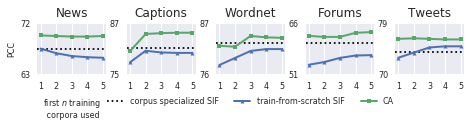

In [0]:
concatResult = np.array(list(ca_all_train_result) + (list(sif_all_train_result))) # for the convenience of plot

sif_all_train_result = np.array(sif_all_train_result)
ca_all_train_result = np.array(ca_all_train_result)
no_stopword_ca_all_train_result = np.array(no_stopword_ca_all_train_result)


width = 6.3
height = width / 1.618 / 5

fig = plt.figure()
fig.subplots_adjust(left=.05, bottom=.05, right=.99, top= 0.97, wspace = 0.3)


for i in range(len(df_list)):
    # i = 0    
    this_ax = fig.add_subplot('15' + str(i + 1))

    this_ax.axhline(y= SIF_specialize_result[i] , color = 'k', linestyle = ':',label = 'corpus specialized SIF')

    this_ax.plot(np.array([1,2,3,4,5]), 
            sif_all_train_result[:,i], 
            linewidth=2, 
            linestyle='-', 
            marker = '^',
            markersize=4,
            label='train-from-scratch SIF'
            );

    this_ax.plot(np.array([1,2,3,4,5]), 
            ca_all_train_result[:,i], 
            linewidth=2, 
            linestyle='-', 
            marker = 's',
            markersize=4,
            label='CA'
            );

    if i == math.floor(len(df_list)/2):
        legend = this_ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol= 3 ,fontsize='8')

    if i == 0:
        this_ax.set_ylabel(r"PCC")
        this_ax.set_xlabel(r"first $n$ training" + "\n corpora used")


    this_ax.set_title(df_list[i].capitalize() )

    plt.setp([this_ax], xticks=[1,2,3,4,5])

    plt.sca(this_ax)

    minMax = [math.floor(np.min(concatResult[:, i]) - 2), math.ceil(np.max(concatResult[:, i]) + 2)]
    this_ax.set_ylim(minMax)
    plt.yticks(minMax)

fig.set_size_inches(width, height)
